In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(50)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-2/netifier/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

train_labels = train_data.columns[2:6]
val_labels = val_data.columns[2:6]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(6218,) (6218, 4)
(1555,) (1555, 4)


# BULDING DATASET

In [9]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [10]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

In [11]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [12]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [13]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

In [14]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

In [15]:
def combined_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)
    
    current_train_size = len(train_indices)
    
    # Check nearest checkpoint
    nearest_cp = 0
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    target_samples = math.ceil(0.1*len(remaining_indices))
    if target_samples <= min_increment and min_increment < nearest_cp - current_train_size:
        target_samples = min_increment
    elif target_samples > min_increment and target_samples < nearest_cp - current_train_size:
        target_samples = target_samples
    else:
        target_samples = nearest_cp - current_train_size

    final_cp = False
    # No sampling needed when there's little data left or we've reached the last checkpoint
    if current_train_size >= checkpoints[-1] - target_samples:
        final_cp = True

        if accelerator.is_main_process:
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            
            sampling_dur.append(0)
            for i in remaining_indices:
                new_samples.append(i)

    accelerator.wait_for_everyone()
    if not final_cp:
        # Create dataset and dataloader for both methods
        dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            num_workers=4,
            pin_memory=True,
        )
        
        # Start timing
        start_time = time.time()
    
        # Get Coreset samples
        coreset_samples = get_coreset_samples(model, farthest_point, dataloader, dataset, device, target_samples)
        coreset_samples = [remaining_indices[i] for i in coreset_samples]
        accelerator.print(f"Got {len(coreset_samples)} samples from coreset")
        
        # Get Least Confidence samples
        lc_indices = get_least_confidence_samples(model, dataloader, device, target_samples)
        lc_indices = [remaining_indices[i] for i in lc_indices]
        accelerator.print(f"Got {len(lc_indices)} samples from lc")
    
        if accelerator.is_main_process:
            # Combine both methods' results
            combined_indices = list(set(coreset_samples).union(set(lc_indices)))
            
            # If we got more than we need, take only what we need
            if len(combined_indices) > target_samples:
                np.random.shuffle(combined_indices)
                combined_indices = combined_indices[:target_samples]
            
            # Calculate duration
            end_time = time.time()
            duration = end_time - start_time
            
            # Check if we've reached a checkpoint
            if current_train_size + len(combined_indices) >= nearest_cp:
                temp = train_indices.copy()
                temp.extend(combined_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
                acquired_data.to_csv(f'acquired_data/{filename}-data-{nearest_cp}.csv', index=False)
            
            # Log results
            print("Nearest checkpoint:", nearest_cp)
            print(f"Acquired samples: {len(combined_indices)}")
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in combined_indices:
                new_samples.append(i)

def get_coreset_samples(model, farthest_point, dataloader, dataset, device, n_samples, n_clusters=min_increment):
    model.eval()
    embeddings = []
    farthest_data = dict(farthest_point)
    
    # Get embeddings
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    distance_matrix = pairwise_distances(embeddings)    
    selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
    
    min_distances = distance_matrix[selected_indices]
    sorted_dist = np.argsort(min_distances)
    sorted_dist = sorted_dist[::-1]
    farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
    farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']

    threshold = np.percentile(min_distances, 90)
    candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
    num_of_candidates = len(candidates)

    return sorted_dist[:n_samples]

def get_least_confidence_samples(model, dataloader, device, n_samples):
    model.eval()
    uncertainties = []
    
    # Calculate uncertainties
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
        
        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]  # Reverse to get highest uncertainty first

    threshold = np.percentile(uncertainties, 90)
    items_greater_than_average = uncertainties[uncertainties >= threshold]
    least_confident_indices = sorted_unc[:n_samples]

    return least_confident_indices

In [16]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()
    filename = 'netifier-lc-coreset'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
        notebook_launcher(combined_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-results.csv', index=False)

In [17]:
seeds = [50, 81, 14, 3, 94]

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5903, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4917, Accuracy: 0.7867, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4703, Accuracy: 0.8167, F1 Micro: 0.259, F1 Macro: 0.187
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.398, Accuracy: 0.8417, F1 Micro: 0.4813, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3739, Accuracy: 0.8522, F1 Micro: 0.5456, F1 Macro: 0.4863
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3021, Accuracy: 0.8609, F1 Micro: 0.6048, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2618, Accuracy: 0.867, F1 Micro: 0.678, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2249, Accuracy: 0.8678, F1 Micro: 0.68, F1 Macro: 0.6722
Epoch 9/10, Train Loss: 0.1872, Accuracy: 0.8722, F1 Micro: 0.6715, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4472, Accuracy: 0.8169, F1 Micro: 0.2478, F1 Macro: 0.1714
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2841, Accuracy: 0.8272, F1 Micro: 0.3424, F1 Macro: 0.2096
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2322, Accuracy: 0.8377, F1 Micro: 0.4476, F1 Macro: 0.3419
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1953, Accuracy: 0.865, F1 Micro: 0.6409, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1568, Accuracy: 0.8714, F1 Micro: 0.6606, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1245, Accuracy: 0.8734, F1 Micro: 0.6734, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0981, Accuracy: 0.8745, F1 Micro: 0.7018, F1 Macro: 0.6927
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.8758, F1 Micro: 0.6689, F1 Macro: 0.641
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0674, Accuracy: 0.8772, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4599, Accuracy: 0.8278, F1 Micro: 0.3518, F1 Macro: 0.2667
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2735, Accuracy: 0.8514, F1 Micro: 0.6145, F1 Macro: 0.6213
Epoch 3/10, Train Loss: 0.2198, Accuracy: 0.8634, F1 Micro: 0.6119, F1 Macro: 0.5992
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1942, Accuracy: 0.8734, F1 Micro: 0.6394, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.8752, F1 Micro: 0.6485, F1 Macro: 0.629
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.8809, F1 Micro: 0.6947, F1 Macro: 0.6811
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.8848, F1 Micro: 0.6996, F1 Macro: 0.6888
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0733, Accuracy: 0.883, F1 Micro: 0.7015, F1 Macro: 0.6913
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.8866, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4078, Accuracy: 0.825, F1 Micro: 0.3785, F1 Macro: 0.2493
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.8587, F1 Micro: 0.612, F1 Macro: 0.6029
Epoch 3/10, Train Loss: 0.1802, Accuracy: 0.8647, F1 Micro: 0.6071, F1 Macro: 0.5846
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.8759, F1 Micro: 0.6581, F1 Macro: 0.6416
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1077, Accuracy: 0.8836, F1 Micro: 0.6847, F1 Macro: 0.6737
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.883, F1 Micro: 0.7052, F1 Macro: 0.6842
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.8845, F1 Micro: 0.705, F1 Macro: 0.6851
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0538, Accuracy: 0.8872, F1 Micro: 0.7162, F1 Macro: 0.7044
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.8872, F1 Micro: 0.7223, F1 Macro: 0.7103
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3925, Accuracy: 0.8533, F1 Micro: 0.5675, F1 Macro: 0.5524
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2178, Accuracy: 0.8606, F1 Micro: 0.6567, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.8814, F1 Micro: 0.7013, F1 Macro: 0.6991
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.8853, F1 Micro: 0.6964, F1 Macro: 0.6731
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.8888, F1 Micro: 0.7053, F1 Macro: 0.6874
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.888, F1 Micro: 0.7115, F1 Macro: 0.6927
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0635, Accuracy: 0.8897, F1 Micro: 0.7309, F1 Macro: 0.7186
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.8814, F1 Micro: 0.7317, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0388, Accuracy: 0.8905, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3733, Accuracy: 0.8462, F1 Micro: 0.6227, F1 Macro: 0.6288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2206, Accuracy: 0.8692, F1 Micro: 0.664, F1 Macro: 0.6603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1688, Accuracy: 0.8877, F1 Micro: 0.7244, F1 Macro: 0.7126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1321, Accuracy: 0.875, F1 Micro: 0.7414, F1 Macro: 0.7389
Epoch 5/10, Train Loss: 0.1061, Accuracy: 0.8947, F1 Micro: 0.7388, F1 Macro: 0.7265
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0782, Accuracy: 0.8841, F1 Micro: 0.7427, F1 Macro: 0.7363
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.057, Accuracy: 0.887, F1 Micro: 0.7482, F1 Macro: 0.7384
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.8927, F1 Micro: 0.7424, F1 Macro: 0.7311
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.8936, F1 Micro: 0.7558, F1 Macro: 0.7483
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.381, Accuracy: 0.8537, F1 Micro: 0.6229, F1 Macro: 0.6278
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2208, Accuracy: 0.8687, F1 Micro: 0.6332, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1772, Accuracy: 0.893, F1 Micro: 0.7514, F1 Macro: 0.7463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.8927, F1 Micro: 0.7519, F1 Macro: 0.7482
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.8917, F1 Micro: 0.7598, F1 Macro: 0.7544
Epoch 6/10, Train Loss: 0.0847, Accuracy: 0.8883, F1 Micro: 0.7534, F1 Macro: 0.7509
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.8934, F1 Micro: 0.7515, F1 Macro: 0.7434
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.8931, F1 Micro: 0.7478, F1 Macro: 0.7323
Epoch 9/10, Train Loss: 0.0357, Accuracy: 0.8959, F1 Micro: 0.7524, F1 Macro: 0.7405
Epoch 10/10, Train Loss: 0.0295, Accuracy: 0.8883, F1 Micro: 0.7513, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3697, Accuracy: 0.8545, F1 Micro: 0.5611, F1 Macro: 0.5451
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2098, Accuracy: 0.8759, F1 Micro: 0.6894, F1 Macro: 0.6899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.8908, F1 Micro: 0.7479, F1 Macro: 0.7437
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.8977, F1 Micro: 0.7398, F1 Macro: 0.7247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1025, Accuracy: 0.8961, F1 Micro: 0.7663, F1 Macro: 0.7616
Epoch 6/10, Train Loss: 0.0756, Accuracy: 0.8916, F1 Micro: 0.7389, F1 Macro: 0.7208
Epoch 7/10, Train Loss: 0.0529, Accuracy: 0.8969, F1 Micro: 0.7428, F1 Macro: 0.7308
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.8992, F1 Micro: 0.7497, F1 Macro: 0.7385
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.8922, F1 Micro: 0.755, F1 Macro: 0.7446
Epoch 10/10, Train Loss: 0.0242, Accuracy: 0.8997, F1 Micro: 0.7599, F1 Macro: 0.7447

 Iteration 3432: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3631, Accuracy: 0.8573, F1 Micro: 0.6175, F1 Macro: 0.6195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2178, Accuracy: 0.8878, F1 Micro: 0.7391, F1 Macro: 0.7322
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.8947, F1 Micro: 0.7332, F1 Macro: 0.7282
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1448, Accuracy: 0.8952, F1 Micro: 0.7508, F1 Macro: 0.7442
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1067, Accuracy: 0.8955, F1 Micro: 0.7572, F1 Macro: 0.7507
Epoch 6/10, Train Loss: 0.0793, Accuracy: 0.8997, F1 Micro: 0.7559, F1 Macro: 0.7496
Epoch 7/10, Train Loss: 0.0568, Accuracy: 0.8958, F1 Micro: 0.7529, F1 Macro: 0.7474
Epoch 8/10, Train Loss: 0.048, Accuracy: 0.898, F1 Micro: 0.7454, F1 Macro: 0.7339
Epoch 9/10, Train Loss: 0.0362, Accuracy: 0.8952, F1 Micro: 0.7559, F1 Macro: 0.7458
Epoch 10/10, Train Loss: 0.0322, Accuracy: 0.8942, F1 Micro: 0.7395, F1 Macro: 0.729

 Iteration 3711: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3618, Accuracy: 0.8591, F1 Micro: 0.6071, F1 Macro: 0.6047
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2054, Accuracy: 0.8869, F1 Micro: 0.7118, F1 Macro: 0.7084
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.8983, F1 Micro: 0.7539, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1368, Accuracy: 0.8948, F1 Micro: 0.7541, F1 Macro: 0.742
Epoch 5/10, Train Loss: 0.1045, Accuracy: 0.8958, F1 Micro: 0.7534, F1 Macro: 0.7455
Epoch 6/10, Train Loss: 0.0719, Accuracy: 0.892, F1 Micro: 0.7533, F1 Macro: 0.7486
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0561, Accuracy: 0.8952, F1 Micro: 0.7596, F1 Macro: 0.7462
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.8967, F1 Micro: 0.7558, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0301, Accuracy: 0.8966, F1 Micro: 0.7677, F1 Macro: 0.763
Epoch 10/10, Train Loss: 0.0258, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3637, Accuracy: 0.8625, F1 Micro: 0.605, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.22, Accuracy: 0.8917, F1 Micro: 0.7305, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1727, Accuracy: 0.8961, F1 Micro: 0.7427, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1427, Accuracy: 0.8964, F1 Micro: 0.7676, F1 Macro: 0.7611
Epoch 5/10, Train Loss: 0.1051, Accuracy: 0.8859, F1 Micro: 0.6917, F1 Macro: 0.6428
Epoch 6/10, Train Loss: 0.083, Accuracy: 0.9008, F1 Micro: 0.7601, F1 Macro: 0.7574
Epoch 7/10, Train Loss: 0.0632, Accuracy: 0.8977, F1 Micro: 0.7673, F1 Macro: 0.7574
Epoch 8/10, Train Loss: 0.0445, Accuracy: 0.8911, F1 Micro: 0.7624, F1 Macro: 0.7551
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.8994, F1 Micro: 0.759, F1 Macro: 0.7519
Epoch 10/10, Train Loss: 0.0274, Accuracy: 0.8919, F1 Micro: 0.7648, F1 Macro: 0.7602

 Iteration 4120: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3554, Accuracy: 0.8647, F1 Micro: 0.6178, F1 Macro: 0.6089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2207, Accuracy: 0.89, F1 Micro: 0.7022, F1 Macro: 0.6858
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1813, Accuracy: 0.8978, F1 Micro: 0.7455, F1 Macro: 0.7397
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1385, Accuracy: 0.893, F1 Micro: 0.7619, F1 Macro: 0.7566
Epoch 5/10, Train Loss: 0.107, Accuracy: 0.8984, F1 Micro: 0.7433, F1 Macro: 0.7367
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.079, Accuracy: 0.9013, F1 Micro: 0.7752, F1 Macro: 0.765
Epoch 7/10, Train Loss: 0.0615, Accuracy: 0.8988, F1 Micro: 0.7676, F1 Macro: 0.7614
Epoch 8/10, Train Loss: 0.0432, Accuracy: 0.8939, F1 Micro: 0.7588, F1 Macro: 0.748
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.8952, F1 Micro: 0.761, F1 Macro: 0.753
Epoch 10/10, Train Loss: 0.0304, Accuracy: 0.9, F1 Micro: 0.7638, F1 Macro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3636, Accuracy: 0.8633, F1 Micro: 0.6233, F1 Macro: 0.6211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2176, Accuracy: 0.8892, F1 Micro: 0.7158, F1 Macro: 0.7034
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9009, F1 Micro: 0.7535, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9045, F1 Micro: 0.7758, F1 Macro: 0.7613
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.9031, F1 Micro: 0.77, F1 Macro: 0.7573
Epoch 6/10, Train Loss: 0.0816, Accuracy: 0.8961, F1 Micro: 0.7661, F1 Macro: 0.7567
Epoch 7/10, Train Loss: 0.0592, Accuracy: 0.9009, F1 Micro: 0.7731, F1 Macro: 0.7671
Epoch 8/10, Train Loss: 0.0442, Accuracy: 0.8994, F1 Micro: 0.7641, F1 Macro: 0.7553
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.8948, F1 Micro: 0.7661, F1 Macro: 0.7617
Epoch 10/10, Train Loss: 0.0314, Accuracy: 0.8981, F1 Micro: 0.7699, F1 Macro: 0.7666

 Iteration 4530: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3582, Accuracy: 0.8741, F1 Micro: 0.689, F1 Macro: 0.6837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2211, Accuracy: 0.8948, F1 Micro: 0.7611, F1 Macro: 0.752
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1746, Accuracy: 0.8969, F1 Micro: 0.7641, F1 Macro: 0.758
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1431, Accuracy: 0.8964, F1 Micro: 0.7724, F1 Macro: 0.7675
Epoch 5/10, Train Loss: 0.1102, Accuracy: 0.8919, F1 Micro: 0.7641, F1 Macro: 0.761
Epoch 6/10, Train Loss: 0.0801, Accuracy: 0.8978, F1 Micro: 0.7578, F1 Macro: 0.7455
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.8988, F1 Micro: 0.7529, F1 Macro: 0.7432
Epoch 8/10, Train Loss: 0.0458, Accuracy: 0.8966, F1 Micro: 0.7676, F1 Macro: 0.7656
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.8941, F1 Micro: 0.7657, F1 Macro: 0.758
Epoch 10/10, Train Loss: 0.0293, Accuracy: 0.8978, F1 Micro: 0.7637, F1 Macro: 0.7584

 Iteration 4663: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3634, Accuracy: 0.8608, F1 Micro: 0.5877, F1 Macro: 0.5581
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2276, Accuracy: 0.8958, F1 Micro: 0.7646, F1 Macro: 0.7582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1801, Accuracy: 0.9023, F1 Micro: 0.7689, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1526, Accuracy: 0.9048, F1 Micro: 0.7718, F1 Macro: 0.7604
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.8998, F1 Micro: 0.7667, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0836, Accuracy: 0.9006, F1 Micro: 0.774, F1 Macro: 0.7698
Epoch 7/10, Train Loss: 0.0592, Accuracy: 0.8983, F1 Micro: 0.7709, F1 Macro: 0.7658
Epoch 8/10, Train Loss: 0.0431, Accuracy: 0.8911, F1 Micro: 0.7581, F1 Macro: 0.7535
Epoch 9/10, Train Loss: 0.0348, Accuracy: 0.9016, F1 Micro: 0.7712, F1 Macro: 0.7658
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.9003, F1 Micro: 0.7726, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3568, Accuracy: 0.8695, F1 Micro: 0.6475, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2199, Accuracy: 0.8959, F1 Micro: 0.7297, F1 Macro: 0.7242
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1797, Accuracy: 0.8986, F1 Micro: 0.7495, F1 Macro: 0.7334
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9005, F1 Micro: 0.7532, F1 Macro: 0.7464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1029, Accuracy: 0.9016, F1 Micro: 0.7651, F1 Macro: 0.7589
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0799, Accuracy: 0.8991, F1 Micro: 0.7675, F1 Macro: 0.7617
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9034, F1 Micro: 0.7673, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0441, Accuracy: 0.9058, F1 Micro: 0.7786, F1 Macro: 0.7665
Epoch 9/10, Train Loss: 0.0366, Accuracy: 0.9017, F1 Micro: 0.7622, F1 Macro: 0.7533
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3666, Accuracy: 0.8822, F1 Micro: 0.7045, F1 Macro: 0.696
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2198, Accuracy: 0.9042, F1 Micro: 0.7749, F1 Macro: 0.7686
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1795, Accuracy: 0.9055, F1 Micro: 0.7848, F1 Macro: 0.7802
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9016, F1 Micro: 0.7694, F1 Macro: 0.7604
Epoch 5/10, Train Loss: 0.1089, Accuracy: 0.8997, F1 Micro: 0.7743, F1 Macro: 0.7675
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.8973, F1 Micro: 0.7671, F1 Macro: 0.7604
Epoch 7/10, Train Loss: 0.0586, Accuracy: 0.8969, F1 Micro: 0.7616, F1 Macro: 0.7546
Epoch 8/10, Train Loss: 0.0413, Accuracy: 0.8984, F1 Micro: 0.7726, F1 Macro: 0.7652
Epoch 9/10, Train Loss: 0.0355, Accuracy: 0.8992, F1 Micro: 0.7689, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.0259, Accuracy: 0.9036, F1 Micro: 0.7727, F1 Macro: 0.7643

 Iteration 5263: Accuracy: 0.9055, F1 Micro: 0.784

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3604, Accuracy: 0.8677, F1 Micro: 0.6018, F1 Macro: 0.567
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.227, Accuracy: 0.8972, F1 Micro: 0.7376, F1 Macro: 0.7294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1841, Accuracy: 0.9059, F1 Micro: 0.7706, F1 Macro: 0.7571
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9056, F1 Micro: 0.7736, F1 Macro: 0.7639
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.903, F1 Micro: 0.7703, F1 Macro: 0.7669
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0801, Accuracy: 0.9052, F1 Micro: 0.7833, F1 Macro: 0.7776
Epoch 7/10, Train Loss: 0.0613, Accuracy: 0.9038, F1 Micro: 0.7705, F1 Macro: 0.7618
Epoch 8/10, Train Loss: 0.0453, Accuracy: 0.9023, F1 Micro: 0.7728, F1 Macro: 0.7655
Epoch 9/10, Train Loss: 0.0334, Accuracy: 0.8994, F1 Micro: 0.7755, F1 Macro: 0.7697
Epoch 10/10, Train Loss: 0.0278, Accuracy: 0.9006, F1 Micro: 0.7761, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3549, Accuracy: 0.8866, F1 Micro: 0.7144, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2257, Accuracy: 0.8959, F1 Micro: 0.7405, F1 Macro: 0.7284
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1914, Accuracy: 0.9047, F1 Micro: 0.7641, F1 Macro: 0.7585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9053, F1 Micro: 0.7754, F1 Macro: 0.7634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1133, Accuracy: 0.9005, F1 Micro: 0.7795, F1 Macro: 0.7752
Epoch 6/10, Train Loss: 0.0804, Accuracy: 0.9036, F1 Micro: 0.7747, F1 Macro: 0.7654
Epoch 7/10, Train Loss: 0.0611, Accuracy: 0.9005, F1 Micro: 0.7774, F1 Macro: 0.7742
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9009, F1 Micro: 0.7769, F1 Macro: 0.7709
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.898, F1 Micro: 0.7647, F1 Macro: 0.7604
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.9025, F1 Micro: 0.7687, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3606, Accuracy: 0.885, F1 Micro: 0.7337, F1 Macro: 0.7307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.224, Accuracy: 0.8995, F1 Micro: 0.7441, F1 Macro: 0.7357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.9048, F1 Micro: 0.785, F1 Macro: 0.7817
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.9045, F1 Micro: 0.7857, F1 Macro: 0.7826
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9067, F1 Micro: 0.7861, F1 Macro: 0.7779
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.9031, F1 Micro: 0.7734, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9036, F1 Micro: 0.778, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.9028, F1 Micro: 0.7777, F1 Macro: 0.7745
Epoch 9/10, Train Loss: 0.0356, Accuracy: 0.9009, F1 Micro: 0.7774, F1 Macro: 0.7745
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.9038, F1 Micro: 0.7825, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3719, Accuracy: 0.888, F1 Micro: 0.7213, F1 Macro: 0.7128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2362, Accuracy: 0.9006, F1 Micro: 0.762, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1866, Accuracy: 0.8989, F1 Micro: 0.7783, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1551, Accuracy: 0.9011, F1 Micro: 0.7834, F1 Macro: 0.7813
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9058, F1 Micro: 0.7767, F1 Macro: 0.771
Epoch 6/10, Train Loss: 0.0886, Accuracy: 0.9006, F1 Micro: 0.7764, F1 Macro: 0.7744
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9048, F1 Micro: 0.7789, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.8998, F1 Micro: 0.7712, F1 Macro: 0.77
Epoch 9/10, Train Loss: 0.0377, Accuracy: 0.9039, F1 Micro: 0.774, F1 Macro: 0.7683
Epoch 10/10, Train Loss: 0.036, Accuracy: 0.9009, F1 Micro: 0.7615, F1 Macro: 0.7568

 Iteration 6041: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3666, Accuracy: 0.8886, F1 Micro: 0.7389, F1 Macro: 0.735
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.8989, F1 Micro: 0.7548, F1 Macro: 0.7439
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.9042, F1 Micro: 0.7601, F1 Macro: 0.7422
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9042, F1 Micro: 0.763, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9048, F1 Micro: 0.7685, F1 Macro: 0.76
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.903, F1 Micro: 0.7741, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0676, Accuracy: 0.9031, F1 Micro: 0.7678, F1 Macro: 0.76
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.9023, F1 Micro: 0.7728, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0397, Accuracy: 0.9033, F1 Micro: 0.7832, F1 Macro: 0.78
Epoch 10/10, 

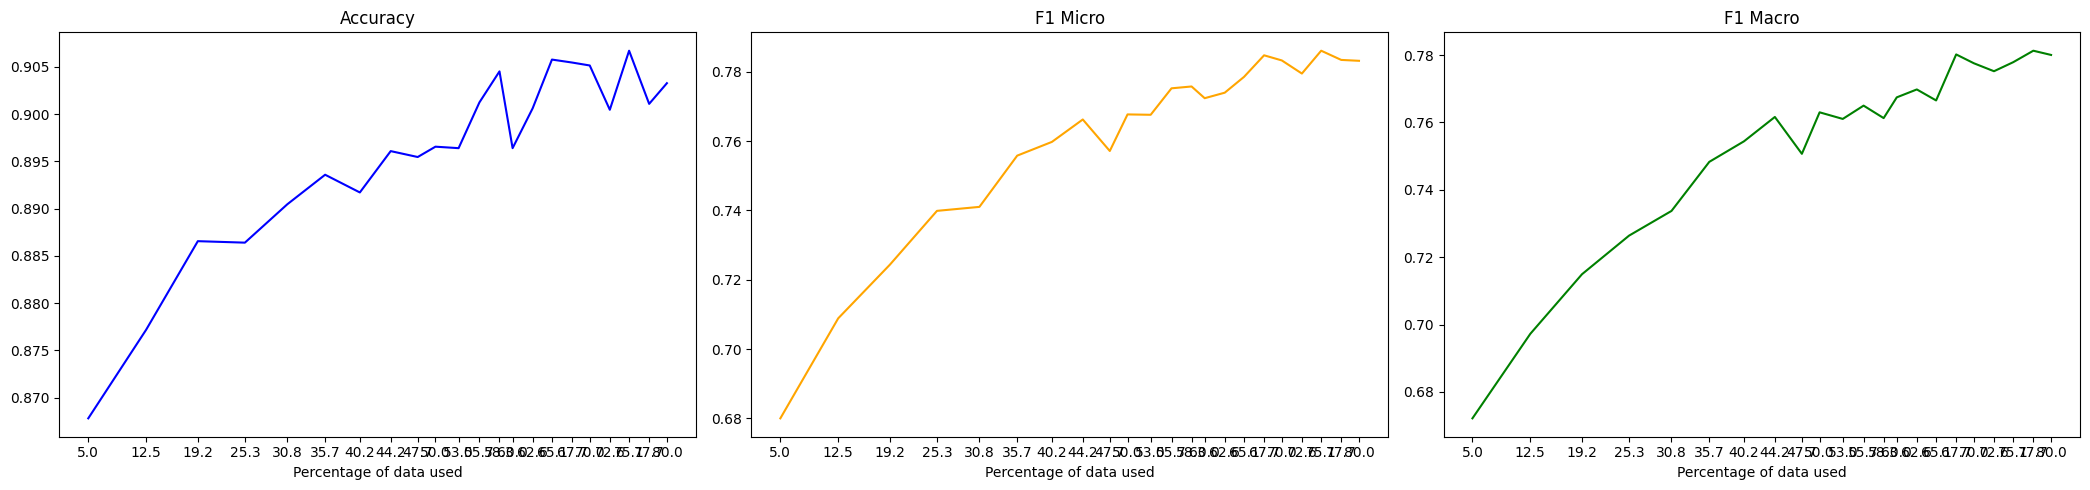

In [18]:
active_learning(seeds[0], 0)